In [1]:
#load
import pandas as pd
df=pd.read_csv("/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv")
print(df)

         Destination Port   Flow Duration   Total Fwd Packets  \
0                    3268       112740690                  32   
1                     389       112740560                  32   
2                       0       113757377                 545   
3                    5355          100126                  22   
4                       0           54760                   4   
...                   ...             ...                 ...   
191028                 53           61452                   4   
191029                 53             171                   2   
191030                 53             222                   2   
191031                123           16842                   1   
191032                 53             153                   2   

         Total Backward Packets  Total Length of Fwd Packets  \
0                            16                         6448   
1                            16                         6448   
2                          

 Label
BENIGN    189067
Bot         1966
Name: count, dtype: int64


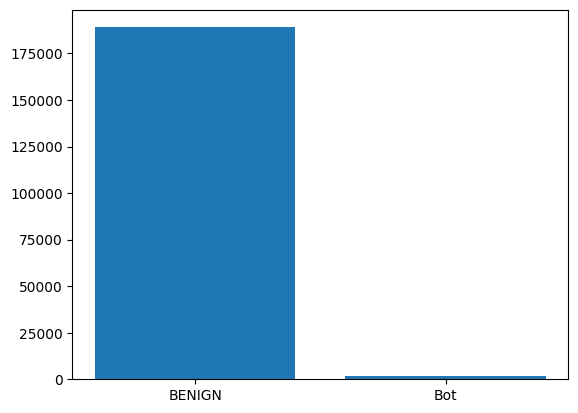

In [2]:
#visaulize
import pandas as pd
import matplotlib.pyplot as plt
data=df[' Label']
counts = data.value_counts()
plt.bar(counts.index, counts.values)
print(counts)

In [3]:
#dropnas
df.dropna()
print(df)
#remove space because dumb dumbs
df.columns = df.columns.str.strip()
columns = df.columns
print(columns)

         Destination Port   Flow Duration   Total Fwd Packets  \
0                    3268       112740690                  32   
1                     389       112740560                  32   
2                       0       113757377                 545   
3                    5355          100126                  22   
4                       0           54760                   4   
...                   ...             ...                 ...   
191028                 53           61452                   4   
191029                 53             171                   2   
191030                 53             222                   2   
191031                123           16842                   1   
191032                 53             153                   2   

         Total Backward Packets  Total Length of Fwd Packets  \
0                            16                         6448   
1                            16                         6448   
2                          

In [4]:
import pandas as pd
from scipy import stats

statistically_sig = []

for col in df.columns:
    if col == "Label":
        continue  # Skip the label column itself
    
    benign = df[df["Label"] == "BENIGN"][col]
    ddos = df[df["Label"] == "Bot"][col]
    
    # Handle numerical columns (int/float)
    if pd.api.types.is_numeric_dtype(df[col]):

        # Check normality (Shapiro-Wilk) and variance (Levene)
        _, p_benign = stats.shapiro(benign)
        _, p_ddos = stats.shapiro(ddos)
        _, p_levene = stats.levene(benign, ddos)
        
        # Decide test: t-test if normal & equal variance, else Mann-Whitney U
        if p_benign > 0.05 and p_ddos > 0.05 and p_levene > 0.05:
            _, p_value = stats.ttest_ind(benign, ddos)
            test_used = "t-test"
        else:
            _, p_value = stats.mannwhitneyu(benign, ddos)
            test_used = "Mann-Whitney U"
    
    # Handle categorical columns (strings/objects)
    else:
        # Create contingency table
        contingency_table = pd.crosstab(df[col], df["Label"])
        
        # Skip if any expected frequency is too low for Chi-square
        if (contingency_table.values < 5).any():
            continue
        
        # Chi-square test
        _, p_value, _, _ = stats.chi2_contingency(contingency_table)
        test_used = "Chi-square"
    
    # Ensure p_value is float (sometimes Chi-square returns array)
    p_value = float(p_value) if hasattr(p_value, '__iter__') else p_value
    
    if p_value < 0.05:
        statistically_sig.append(col)

# Print results
print("Statistically significant features (p < 0.05):")


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 189067.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_morestats.py:3048: RuntimeWarning: invalid value encountered in subtract
  numer = (Ntot - k) * np.sum(Ni * (Zbari - Zbar)**2, axis=0)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_morestats.py:3053: RuntimeWarning: invalid value encountered in subtract
  dvar += np.sum((Zij[i] - Zbari[i])**2, axis=0)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2215: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dis

Statistically significant features (p < 0.05):


In [5]:
print(len(statistically_sig))
print(statistically_sig)

61
['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd B

In [6]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

best_feat = []
df2 = df.copy()

# Binary label: 1 if DDoS, 0 otherwise
y_true = (df2['Label'] == "Bot").astype(int)

for col in statistically_sig:
    # Encode non-numeric features
    if not np.issubdtype(df2[col].dtype, np.number):
        df2[col] = LabelEncoder().fit_transform(df2[col].astype(str))
    
    # Ensure column is numeric and clean
    df2[col] = pd.to_numeric(df2[col], errors='coerce')
    df2[col].replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop rows with NaN or inf and align y_true
    mask = df2[col].notna()
    if mask.sum() == 0:
        continue  # Skip if all values are invalid
    try:
        auc = roc_auc_score(y_true[mask], df2[col][mask])
        if auc > 0.60:
            best_feat.append(col)
    except ValueError as e:
        print(f"Skipping {col}: {e}")


/tmp/ipykernel_13/3451620642.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2[col].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_13/3451620642.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

In [7]:
print(len(best_feat))
print(best_feat)

10
['Destination Port', 'Flow IAT Min', 'Fwd IAT Std', 'Bwd IAT Std', 'Bwd IAT Min', 'Bwd Packets/s', 'PSH Flag Count', 'URG Flag Count', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward']


In [8]:
#drop even more useless bois
best_feat.append("Label")


df3=df[best_feat]

print(df3)

        Destination Port  Flow IAT Min   Fwd IAT Std  Bwd IAT Std  \
0                   3268             3  6.848761e+06  8323384.915   
1                    389             2  6.848777e+06  8323376.147   
2                      0             0  1.395543e+06        0.000   
3                   5355             1  2.183302e+04        0.000   
4                      0           108  3.046984e+04        0.000   
...                  ...           ...           ...          ...   
191028                53             3  1.566640e+04        0.000   
191029                53             4  0.000000e+00        0.000   
191030                53             4  0.000000e+00        0.000   
191031               123         16842  0.000000e+00        0.000   
191032                53             2  0.000000e+00        0.000   

        Bwd IAT Min  Bwd Packets/s  PSH Flag Count  URG Flag Count  \
0                 3       0.141919               0               0   
1                 4       0.141

/tmp/ipykernel_13/3527071079.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Label'] = df3['Label'].map({'BENIGN': 0, 'Bot': 1})


Label
0    189067
1      1966
Name: count, dtype: int64


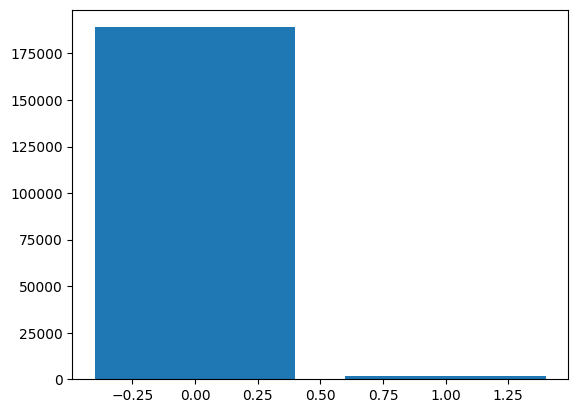

In [9]:
#convert bengin to 0 and ddos to 1
df3['Label'] = df3['Label'].map({'BENIGN': 0, 'Bot': 1})
#visaulize
import pandas as pd
import matplotlib.pyplot as plt
data=df3['Label']
counts = data.value_counts()
plt.bar(counts.index, counts.values)
print(counts)

In [10]:
#scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
for col in best_feat:
    if col =="Label":
        print("opsie")
        continue
    scaler = MinMaxScaler()
    df[[col]] = scaler.fit_transform(df[[col]])
df3=df[best_feat]
print(df3)

opsie
        Destination Port  Flow IAT Min  Fwd IAT Std  Bwd IAT Std  \
0               0.050317  1.344538e-07     0.082021     0.099801   
1               0.005989  1.260504e-07     0.082021     0.099801   
2               0.000000  1.092437e-07     0.016713     0.000000   
3               0.082451  1.176470e-07     0.000261     0.000000   
4               0.000000  1.016807e-06     0.000365     0.000000   
...                  ...           ...          ...          ...   
191028          0.000816  1.344538e-07     0.000188     0.000000   
191029          0.000816  1.428571e-07     0.000000     0.000000   
191030          0.000816  1.428571e-07     0.000000     0.000000   
191031          0.001894  1.416386e-04     0.000000     0.000000   
191032          0.000816  1.260504e-07     0.000000     0.000000   

         Bwd IAT Min  Bwd Packets/s  PSH Flag Count  URG Flag Count  \
0       2.500000e-08   7.095930e-08             0.0             0.0   
1       3.333333e-08   7.095938e-08

Class weights: {'BENIGN': 0.01029275123342887, 'Bot': 0.9897072487665711}
Fold 1 Accuracy: 96.21%
              precision    recall  f1-score   support

      BENIGN       1.00      0.96      0.98     30251
         Bot       0.21      0.99      0.35       315

    accuracy                           0.96     30566
   macro avg       0.61      0.98      0.67     30566
weighted avg       0.99      0.96      0.97     30566

Fold 2 Accuracy: 96.38%
              precision    recall  f1-score   support

      BENIGN       1.00      0.96      0.98     30251
         Bot       0.22      1.00      0.36       314

    accuracy                           0.96     30565
   macro avg       0.61      0.98      0.67     30565
weighted avg       0.99      0.96      0.97     30565

Fold 3 Accuracy: 96.28%
              precision    recall  f1-score   support

      BENIGN       1.00      0.96      0.98     30251
         Bot       0.22      1.00      0.36       314

    accuracy                        

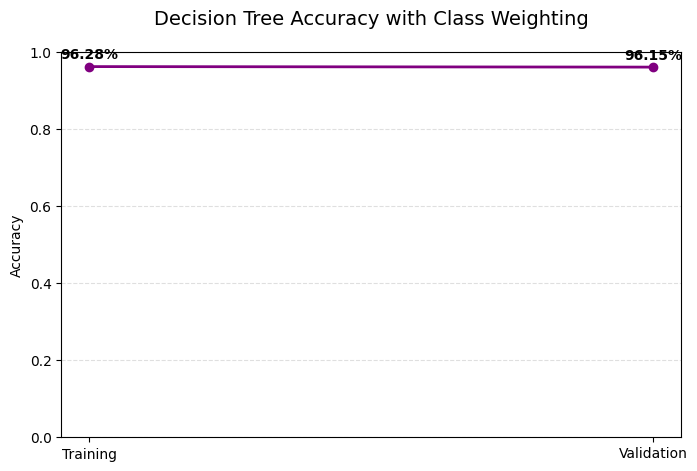

<Figure size 800x600 with 0 Axes>

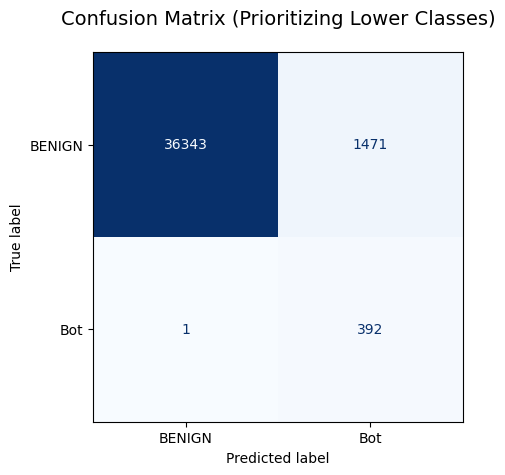


Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      0.96      0.98     37814
         Bot       0.21      1.00      0.35       393

    accuracy                           0.96     38207
   macro avg       0.61      0.98      0.66     38207
weighted avg       0.99      0.96      0.97     38207



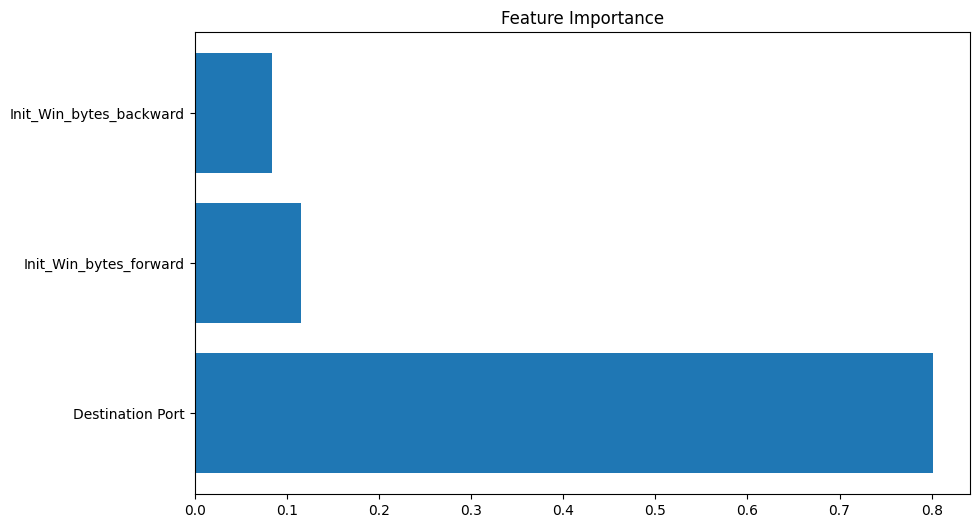

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
X = df3.drop(["Label","Bwd IAT Min","URG Flag Count","Bwd Packets/s","Bwd IAT Std","Fwd IAT Std","Flow IAT Min","PSH Flag Count"], axis=1)
y = df3["Label"]

# Split data into train and test WITH stratification (keeping 20% for final validation)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

# Calculate class weights to prioritize lower classes
class_counts = y_train.value_counts()
class_weights = {cls: 1/(count/len(y_train)) for cls, count in class_counts.items()}
# Normalize weights so they sum to 1
sum_weights = sum(class_weights.values())
class_weights = {k: v/sum_weights for k, v in class_weights.items()}

print("Class weights:", class_weights)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store accuracy scores
fold_accuracies = []

# Perform stratified k-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(skf.split(X_train, y_train)):
    X_fold_train, X_fold_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_fold_train, y_fold_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    # Train Decision Tree with class weights
    model = DecisionTreeClassifier(
        max_depth=5,
        min_samples_split=20,
        random_state=42,
        class_weight='balanced' # using our calculated weights
    )
    
    model.fit(X_fold_train, y_fold_train)
    
    # Get predictions
    fold_pred = model.predict(X_fold_test)
    
    # Evaluate
    fold_acc = accuracy_score(y_fold_test, fold_pred)
    fold_accuracies.append(fold_acc)
    
    print(f"Fold {fold + 1} Accuracy: {fold_acc:.2%}")
    print(classification_report(y_fold_test, fold_pred))

# Calculate average accuracy across folds
avg_fold_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Cross-Validation Accuracy: {avg_fold_accuracy:.2%}")

# Now train on full training data with the same parameters
final_model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=20,
    random_state=42,
    class_weight=class_weights
)
final_model.fit(X_train, y_train)

# Get predictions on validation set
val_pred = final_model.predict(X_val)

# Evaluate
train_acc = accuracy_score(y_train, final_model.predict(X_train))
val_acc = accuracy_score(y_val, val_pred)

print(f"\nFinal Model Training Accuracy: {train_acc:.2%}")
print(f"Final Model Validation Accuracy: {val_acc:.2%}")

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(['Training', 'Validation'], [train_acc, val_acc], 
         marker='o',
         linestyle='-',
         linewidth=2,
         color='purple')

# Add labels
for i, acc in enumerate([train_acc, val_acc]):
    plt.text(i, acc + 0.02, f"{acc:.2%}", ha='center', fontweight='bold')

plt.title('Decision Tree Accuracy with Class Weighting', fontsize=14, pad=20)
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

# Confusion Matrix Plot
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_val, 
    val_pred,
    cmap='Blues',
    display_labels=final_model.classes_,
    colorbar=False
)
plt.title('Confusion Matrix (Prioritizing Lower Classes)', fontsize=14, pad=20)
plt.grid(False)
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, val_pred))

# Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(X.columns, final_model.feature_importances_)
plt.title('Feature Importance')
plt.show()